In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import pairwise_distances

import itertools
from itertools import cycle

from datetime import datetime
%matplotlib inline

In [128]:
orders = pd.read_csv('orders.csv')
print(orders.shape)
orders.head(10)


(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [129]:
prev = orders[orders.eval_set == 'prior']
prev.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [130]:
products = pd.read_csv('products.csv')
products = products.drop(['aisle_id', 'department_id'], axis=1)
print(products.shape)
products.head(10)

(49688, 2)


,product_id,product_name
0,1,Chocolate Sandwich Cookies
1,2,All-Seasons Salt
2,3,Robust Golden Unsweetened Oolong Tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...
4,5,Green Chile Anytime Sauce
5,6,Dry Nose Oil
6,7,Pure Coconut Water With Orange
7,8,Cut Russet Potatoes Steam N' Mash
8,9,Light Strawberry Blueberry Yogurt
9,10,Sparkling Orange Juice & Prickly Pear Beverage


In [131]:
order_products_prior = pd.read_csv('order_products__prior.csv')
print(order_products_prior.shape)
order_products_prior.head(10)

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [132]:
"""order_products_train = pd.read_csv('order_products__train.csv')
print(order_products_train.shape)
order_products_train.head(10)"""

"order_products_train = pd.read_csv('order_products__train.csv')\nprint(order_products_train.shape)\norder_products_train.head(10)"

In [133]:
merged_left = pd.merge(left=order_products_prior,right=products, how='left', left_on='product_id', right_on='product_id')
merged_left.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name
0,2,33120,1,1,Organic Egg Whites
1,2,28985,2,1,Michigan Organic Kale
2,2,9327,3,0,Garlic Powder
3,2,45918,4,1,Coconut Butter
4,2,30035,5,0,Natural Sweetener
5,2,17794,6,1,Carrots
6,2,40141,7,1,Original Unflavored Gelatine Mix
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter
8,2,43668,9,0,Classic Blend Cole Slaw
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...


In [134]:
print(merged_left[merged_left.product_id == 9327])

          order_id  product_id  add_to_cart_order  reordered   product_name
2                2        9327                  3          0  Garlic Powder
527             63        9327                  3          0  Garlic Powder
3979           420        9327                  8          1  Garlic Powder
20356         2160        9327                 15          0  Garlic Powder
34960         3653        9327                 10          0  Garlic Powder
35441         3705        9327                 14          1  Garlic Powder
54877         5810        9327                  3          0  Garlic Powder
59396         6311        9327                  8          0  Garlic Powder
63018         6719        9327                  8          0  Garlic Powder
69215         7357        9327                 12          1  Garlic Powder
70061         7456        9327                 10          0  Garlic Powder
76277         8113        9327                 13          0  Garlic Powder
78481       

In [135]:
merged_data = pd.merge(left=merged_left,right=prev, how='left', left_on='order_id', right_on='order_id')
merged_data.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,202279,prior,3,5,9,8.0
5,2,17794,6,1,Carrots,202279,prior,3,5,9,8.0
6,2,40141,7,1,Original Unflavored Gelatine Mix,202279,prior,3,5,9,8.0
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,202279,prior,3,5,9,8.0
8,2,43668,9,0,Classic Blend Cole Slaw,202279,prior,3,5,9,8.0
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,205970,prior,16,5,17,12.0


In [136]:
# Let's check the data for nulls
null_count = merged_data.isnull().sum()
null_count[null_count>0]

days_since_prior_order    2078068
dtype: int64

In [137]:
merged_data = merged_data.fillna(0)

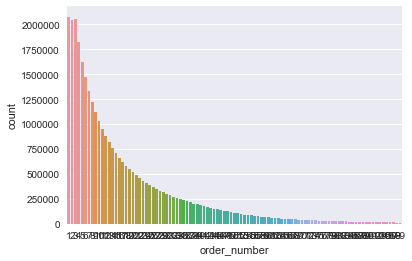

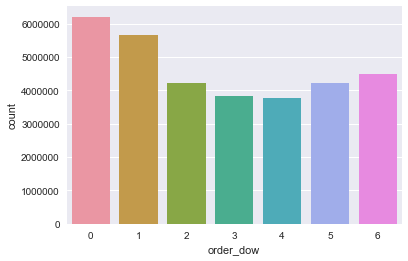

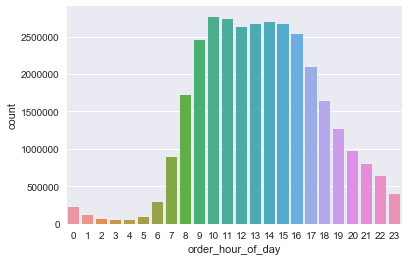

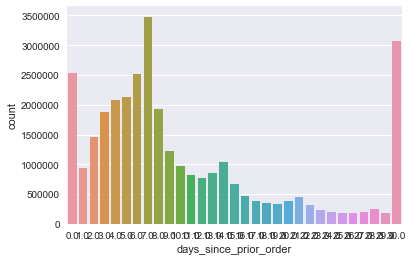

In [138]:
value_count_columns = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
for feature in value_count_columns:
    sns.countplot(x=feature, data=merged_data)
    plt.show()

In [139]:
merged_data['timeframe'] = pd.qcut(merged_data['order_hour_of_day'], 4, labels=False)

In [140]:
"""latenight_snacks = merged_data[merged_data.timeframe == 0]
sns.countplot(x='product_name', data=latenight_snacks)
plt.show()"""

"latenight_snacks = merged_data[merged_data.timeframe == 0]\nsns.countplot(x='product_name', data=latenight_snacks)\nplt.show()"

In [141]:
merged_data['prev_order'] = merged_data['product_id'].shift(1)
merged_data = merged_data[merged_data.add_to_cart_order != 1]
merged_data.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,timeframe,prev_order
1,2,28985,2,1,Michigan Organic Kale,202279,prior,3,5,9,8.0,0,33120.0
2,2,9327,3,0,Garlic Powder,202279,prior,3,5,9,8.0,0,28985.0
3,2,45918,4,1,Coconut Butter,202279,prior,3,5,9,8.0,0,9327.0
4,2,30035,5,0,Natural Sweetener,202279,prior,3,5,9,8.0,0,45918.0
5,2,17794,6,1,Carrots,202279,prior,3,5,9,8.0,0,30035.0
6,2,40141,7,1,Original Unflavored Gelatine Mix,202279,prior,3,5,9,8.0,0,17794.0
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,202279,prior,3,5,9,8.0,0,40141.0
8,2,43668,9,0,Classic Blend Cole Slaw,202279,prior,3,5,9,8.0,0,1819.0
10,3,24838,2,1,Unsweetened Almondmilk,205970,prior,16,5,17,12.0,3,33754.0
11,3,17704,3,1,Lemons,205970,prior,16,5,17,12.0,3,24838.0


In [142]:
merged_data = resample(merged_data, n_samples=100000)
X = merged_data.drop(['order_id', 'product_name', 'eval_set'], 1)

In [143]:
"""kclust = np.arange(2, 7, 1)
for k in kclust:
    # Calculate predicted values.
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Check the solution against the data.
    labelskm = kmeans.labels_
    print(k, metrics.silhouette_score(X, labelskm, metric='euclidean'))"""

"kclust = np.arange(2, 7, 1)\nfor k in kclust:\n    # Calculate predicted values.\n    kmeans = KMeans(n_clusters=k, random_state=42)\n    kmeans.fit(X)\n\n    # Check the solution against the data.\n    labelskm = kmeans.labels_\n    print(k, metrics.silhouette_score(X, labelskm, metric='euclidean'))"

In [144]:
"""bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
    
# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X) 

# Extract cluster assignments for each data point.
labelsms = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labelsms))

print("Number of estimated clusters: {}".format(n_clusters_))
print('Comparing the assigned categories to the ones in the data:')
print(metrics.silhouette_score(X, labelsms, metric='euclidean'))"""

'bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)\n    \n# Declare and fit the model.\nms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X) \n\n# Extract cluster assignments for each data point.\nlabelsms = ms.labels_\n\n# Coordinates of the cluster centers.\ncluster_centers = ms.cluster_centers_\n\n# Count our clusters.\nn_clusters_ = len(np.unique(labelsms))\n\nprint("Number of estimated clusters: {}".format(n_clusters_))\nprint(\'Comparing the assigned categories to the ones in the data:\')\nprint(metrics.silhouette_score(X, labelsms, metric=\'euclidean\'))'

In [145]:
kmeans = KMeans(n_clusters=5, random_state=42)
merged_data_fitted = kmeans.fit(X)
labels = kmeans.labels_
X['clusters'] = labels

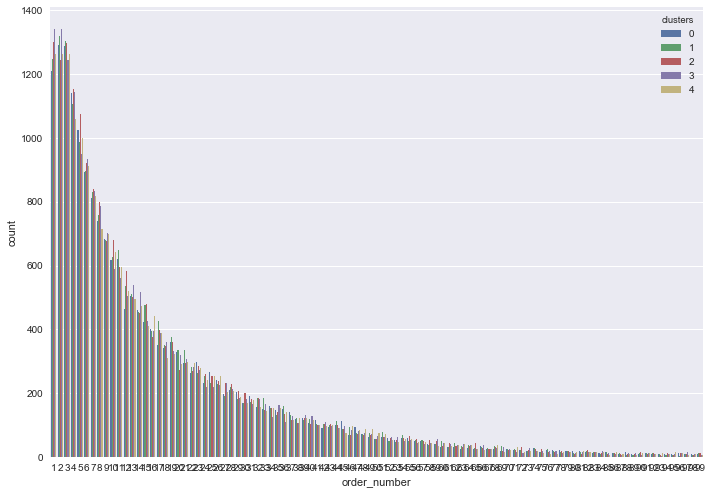

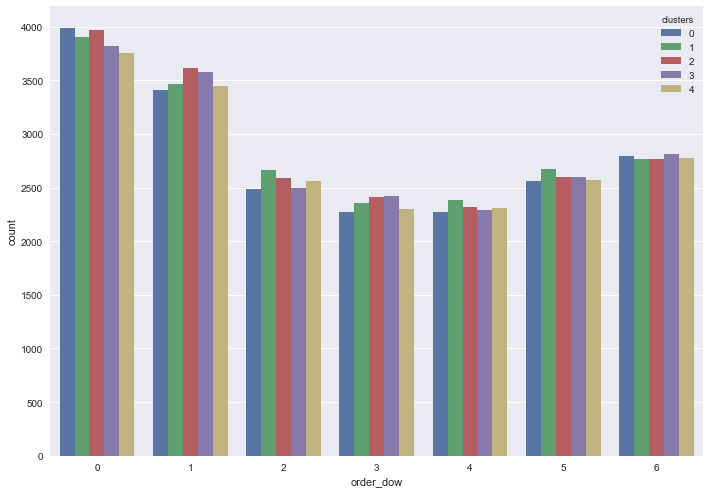

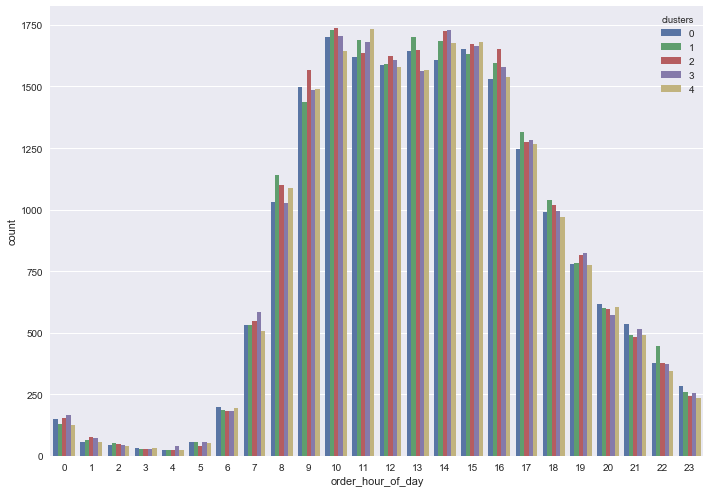

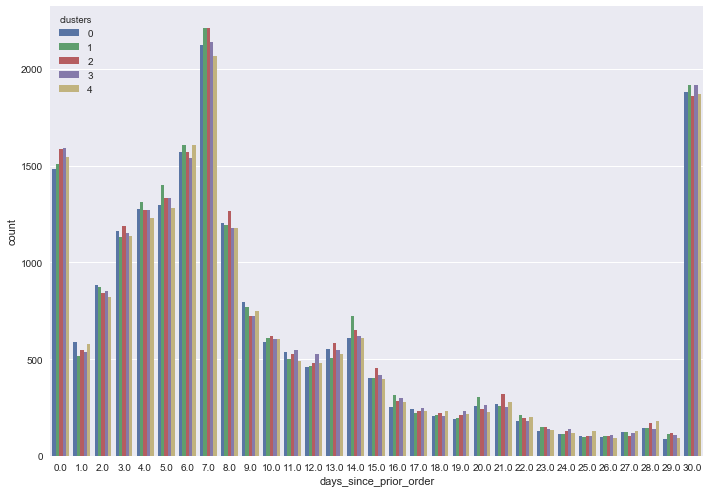

In [146]:

for feature in value_count_columns:
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.countplot(x=feature, hue=X.clusters, data=X, ax=ax)
    plt.show()

In [147]:
kmeans = KMeans(n_clusters=2, random_state=42)
merged_data_fitted = kmeans.fit(X)
labels = kmeans.labels_
X['clusters'] = labels

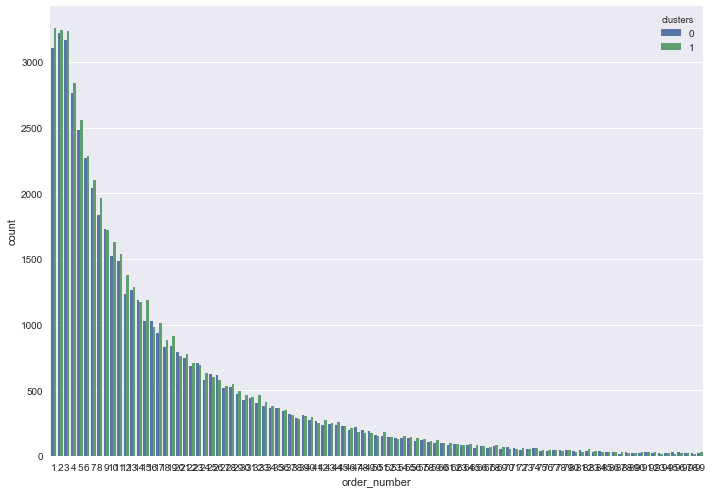

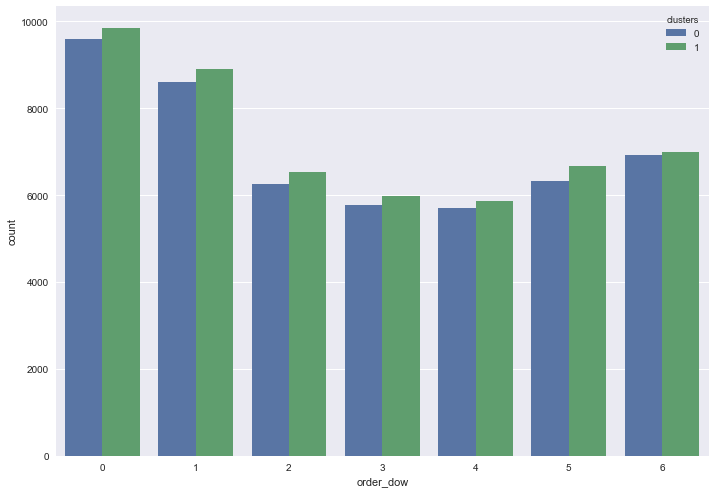

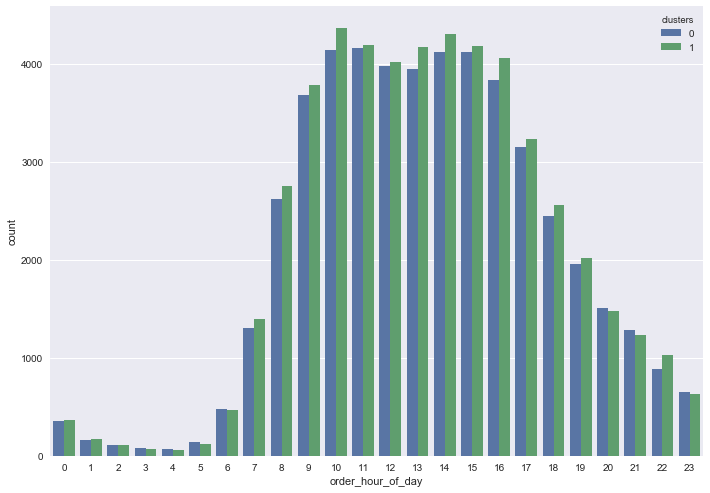

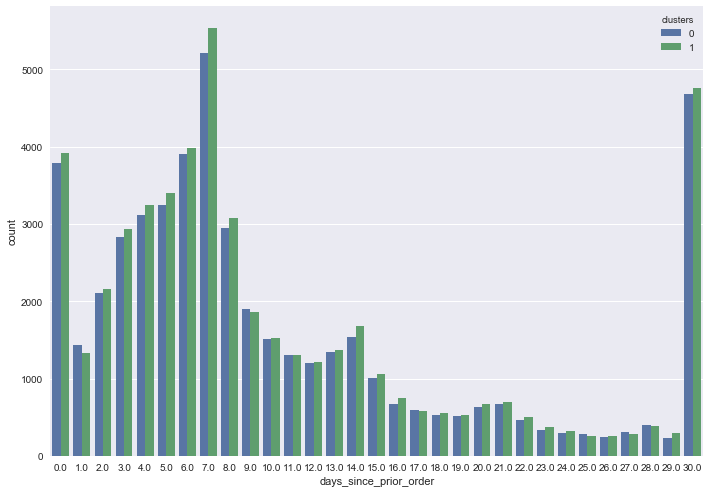

In [148]:
for feature in value_count_columns:
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.countplot(x=feature, hue=X.clusters, data=X, ax=ax)
    plt.show()

In [149]:
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data_fitted = kmeans.fit(X)
labels = kmeans.labels_
X['clusters'] = labels

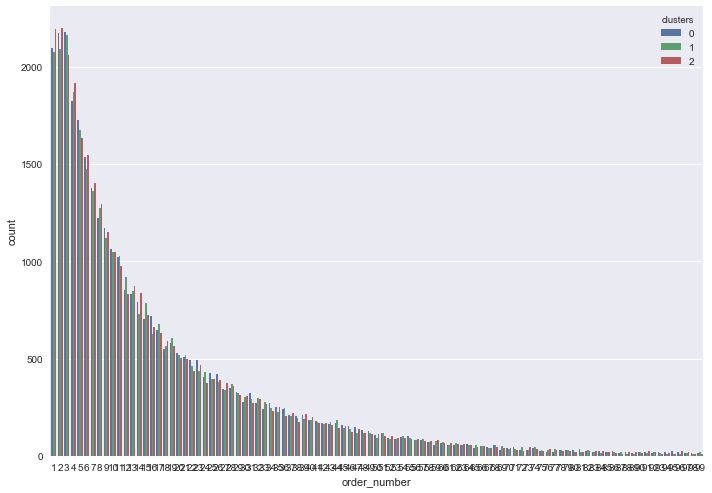

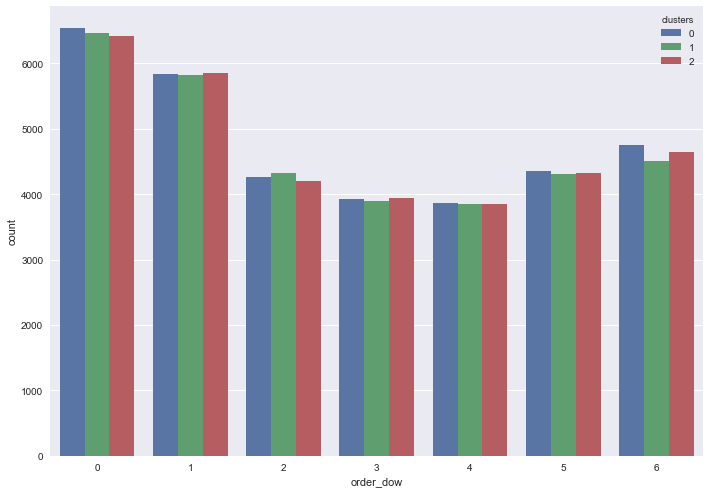

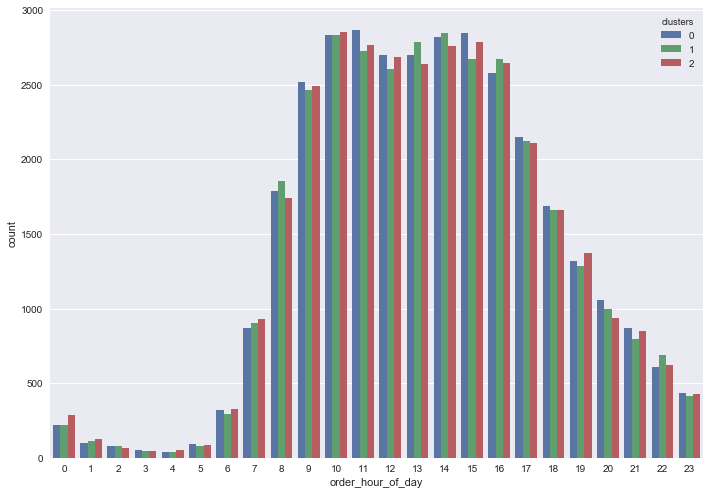

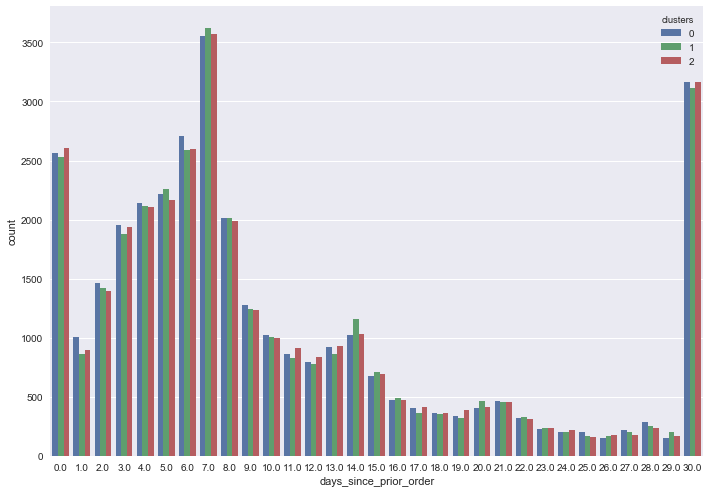

In [150]:
for feature in value_count_columns:
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.countplot(x=feature, hue=X.clusters, data=X, ax=ax)
    plt.show()

In [151]:
kmeans = KMeans(n_clusters=4, random_state=42)
merged_data_fitted = kmeans.fit(X)
labels = kmeans.labels_
X['clusters'] = labels

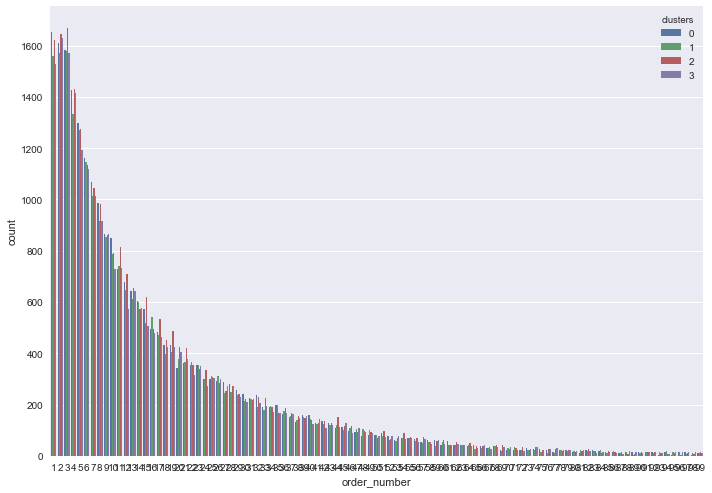

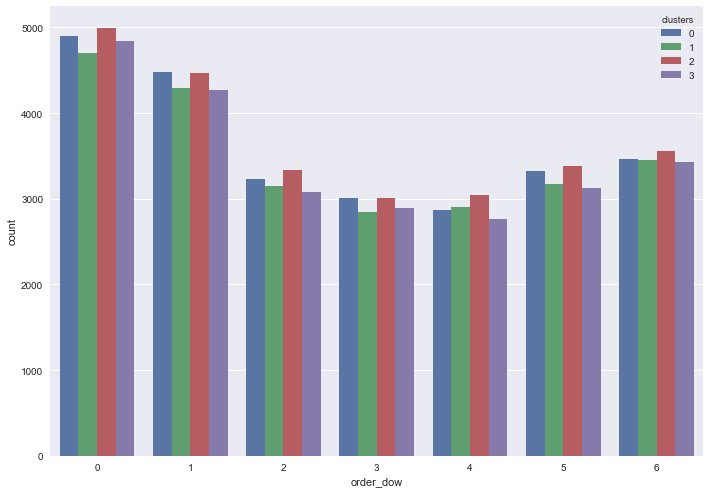

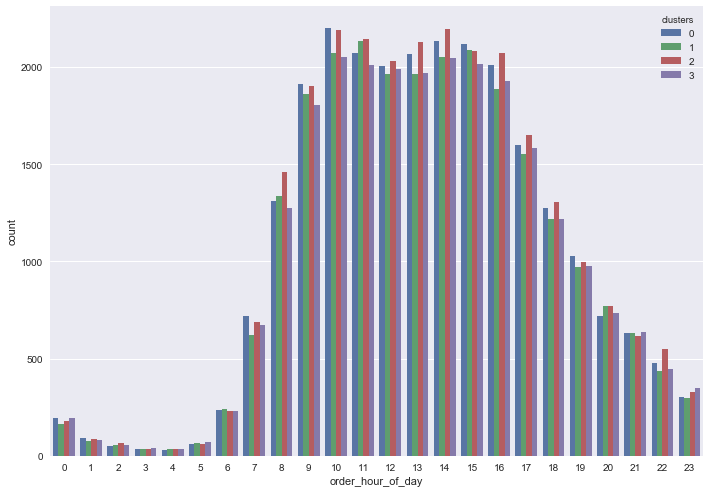

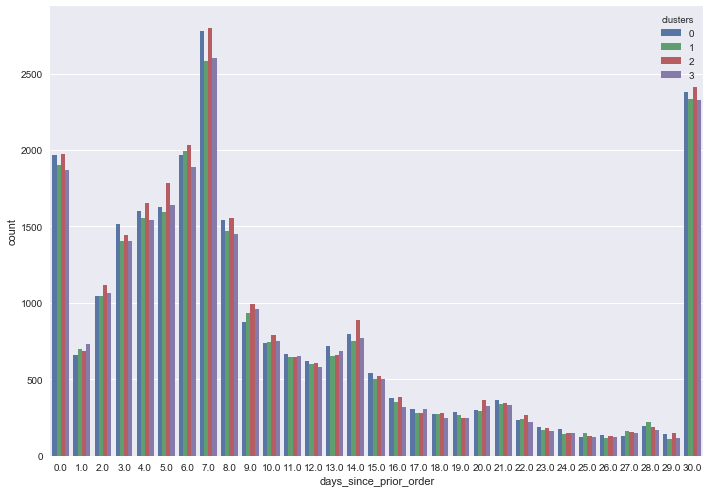

In [152]:
for feature in value_count_columns:
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.countplot(x=feature, hue=X.clusters, data=X, ax=ax)
    plt.show()

In [153]:
kmeans = KMeans(n_clusters=6, random_state=42)
merged_data_fitted = kmeans.fit(X)
labels = kmeans.labels_
X['clusters'] = labels

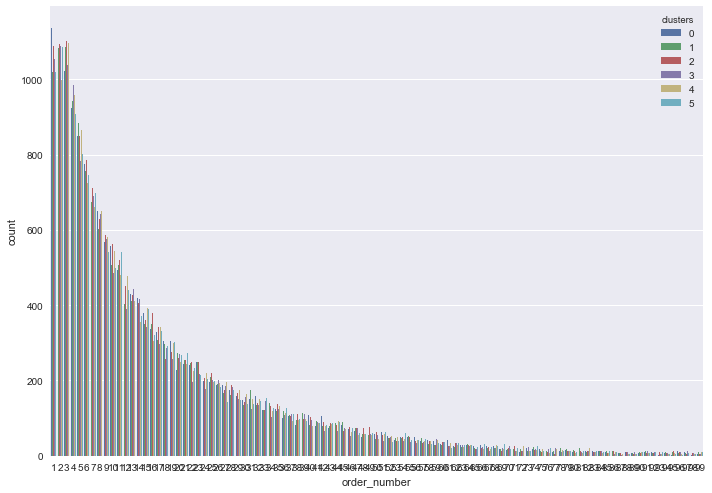

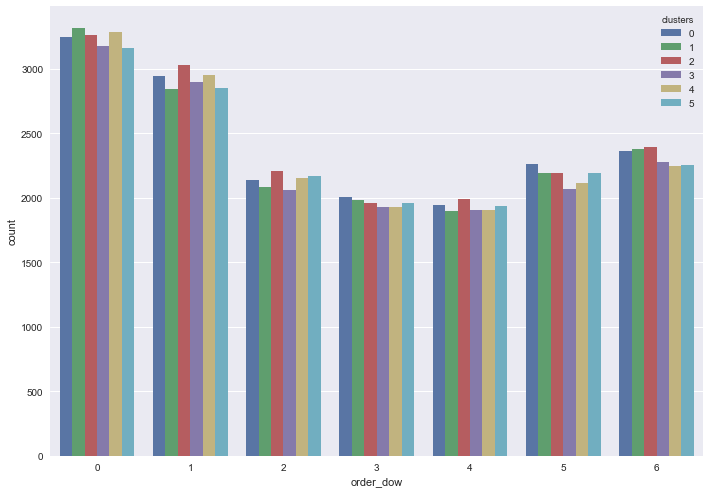

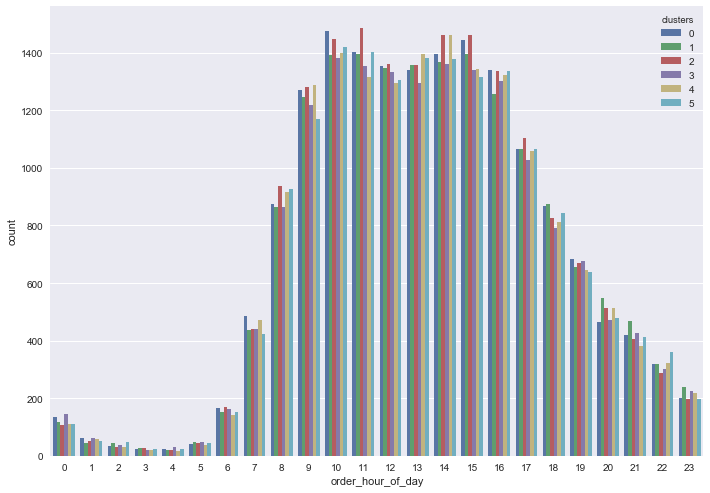

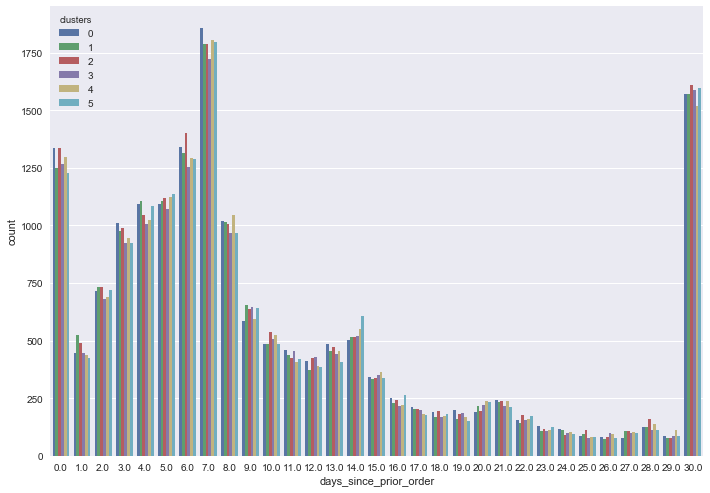

In [154]:
for feature in value_count_columns:
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.countplot(x=feature, hue=X.clusters, data=X, ax=ax)
    plt.show()

In [155]:
grouped = X.groupby(['clusters', 'product_id']).product_id.value_counts().nlargest(100)
print(grouped)
"""grouped = pd.merge(left=grouped,right=products, how='left', left_on='product_id', right_on='product_id')
grouped.head(10)"""

clusters  product_id  product_id
0         24852       24852         224
3         24852       24852         214
4         24852       24852         212
1         24852       24852         210
5         24852       24852         207
4         13176       13176         204
2         13176       13176         194
          24852       24852         194
1         13176       13176         184
0         13176       13176         174
5         13176       13176         164
3         13176       13176         156
2         21903       21903         147
1         21137       21137         145
4         21137       21137         145
0         21137       21137         144
          21903       21903         135
2         21137       21137         132
3         21137       21137         131
5         21137       21137         131
4         21903       21903         129
5         21903       21903         124
3         21903       21903         119
1         47209       47209         117
       

"grouped = pd.merge(left=grouped,right=products, how='left', left_on='product_id', right_on='product_id')\ngrouped.head(10)"

In [156]:
X = X.drop(['product_id'], axis=1)
y = merged_data['product_id']
sample_weight = np.random.RandomState(42).rand(y.shape[0])
X_train, X_test, y_train, y_test, sw_train, sw_test= train_test_split(X, y, sample_weight, test_size=0.4, random_state=0)


In [157]:
#Create a testing function that will fit the test the data.
"""def testing_func(test):
    # This is a local list used to temporarily store scores
    scores=[]
    # This list serves the For loop below putting the variables in   
    for x in models:
        #Fitting to Training Data
        test.fit(X_train, y_train)
        #Training Data Score
        y_pred = model.predict_proba(X_test)
        conf_mat = confusion_matrix(y_test, y_pred)
        ytest_labels = list(set(y_test))
        ypred_labels = list(set(y_pred))
        combined_list = list(set(y_test + y_pred))
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=combined_list, yticklabels=combined_list)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        scores.append(test.score(x[0], x[1]))
        #Test Data Score
        scores.append(test.score(x[2], x[3]))
        #CV Score
        scores.append(np.mean(cross_val_score(test, x[0], x[1], cv=5)))
    
    # Create a local dataframe to display our results cleanly
    local_results_df=pd.DataFrame(scores, columns=['Accuracy'], index=[method])
    print(local_results_df)
    model = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')"""


"def testing_func(test):\n    # This is a local list used to temporarily store scores\n    scores=[]\n    # This list serves the For loop below putting the variables in   \n    for x in models:\n        #Fitting to Training Data\n        test.fit(X_train, y_train)\n        #Training Data Score\n        y_pred = model.predict_proba(X_test)\n        conf_mat = confusion_matrix(y_test, y_pred)\n        ytest_labels = list(set(y_test))\n        ypred_labels = list(set(y_pred))\n        combined_list = list(set(y_test + y_pred))\n        fig, ax = plt.subplots(figsize=(10,10))\n        sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=combined_list, yticklabels=combined_list)\n        plt.ylabel('Actual')\n        plt.xlabel('Predicted')\n        plt.show()\n        scores.append(test.score(x[0], x[1]))\n        #Test Data Score\n        scores.append(test.score(x[2], x[3]))\n        #CV Score\n        scores.append(np.mean(cross_val_score(test, x[0], x[1], cv=5)))\n    \n    # Create 

In [158]:
def testing_func(test):

    test.fit(X_train, y_train) 
    prob_pos_clf = test.predict_proba(X_test)[:, 1]

    """# Gaussian Naive-Bayes with isotonic calibration
    clf_isotonic = CalibratedClassifierCV(test, cv=2, method='isotonic')
    clf_isotonic.fit(X_train, y_train, sw_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

    # Gaussian Naive-Bayes with sigmoid calibration
    clf_sigmoid = CalibratedClassifierCV(test, cv=2, method='sigmoid')
    clf_sigmoid.fit(X_train, y_train, sw_train)
    prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]"""

    print("Brier scores: (the smaller the better)")

    clf_score = brier_score_loss(y_test, prob_pos_clf, sw_test)
    print("No calibration: {}".format(clf_score))

    """clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sw_test)
    print("With isotonic calibration: {}".format(clf_isotonic_score))

    clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sw_test)
    print("With sigmoid calibration: {}".format(clf_sigmoid_score))"""

In [159]:
start = datetime.now()
lr = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
testing_func(lr)
print('\nIt took the following time to complete this task:', datetime.now() - start)

Brier scores: (the smaller the better)
No calibration: 0.0027819473611796187

It took the following time to complete this task: 5:56:58.372706


In [160]:
start = datetime.now()
svc = LinearSVC(C=1, multi_class='ovr')
testing_func(svc)
print('\nIt took the following time to complete this task:', datetime.now() - start)

NameError: name 'LinearSVC' is not defined

In [ ]:
start = datetime.now()
rfc = RandomForestClassifier(n_estimators=100, n_jobs=4)
testing_func(rfc)
print('\n It took the following time to complete this task:', datetime.now() - start)